### **01-Exploración de datos**
### **PROYECTO: DETECCIÓN HISTOPATOLÓGICA DEL CANCER**
### Funamentetos de Deep Learning - 2023-2

$ \mathcal{Daniel ~H. ~Martínez ~S. ~-~ UdeA} $

$ $

**Descripción del notebook:**

En este note book se realiza la exploración de datos, descargando los datos directamente desde kaggle y estudiando el número de imágenes y clases.
Luego se selecciona una muestra de XX imágenes para las clases y dichos datos se suben al github del proyecto (xxx) con el fin de faciliar su análisis y posterior entrenamiento del modelo.

In [1]:
# Instalar las siguientes librerías
!pip install kaggle
!pip install opendatasets

In [2]:
# Librerias
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from skimage import io
from pathlib import Path
from humanize import naturalsize
import tensorflow as tf
from tqdm.auto import tqdm
import h5py

**NOTAS**:
* Los datos completos de las imágenes histopatológicas de `train` y `test`, tienen un tamaño en disco de 7.4 GB.
* Tiempo promedio de descarga y extracción de estos datos es de: 3min+30s
* Utilizar el `username` y el `key` otorgado en el respectivo registro de la página de kaggle.

In [3]:
# Descargando datos desde Kaggle
ds_link = "https://www.kaggle.com/competitions/histopathologic-cancer-detection"
od.download(ds_link)

Skipping, found downloaded files in "./histopathologic-cancer-detection" (use force=True to force download)


In [4]:
dir0 = os.chdir("/content/histopathologic-cancer-detection")
os.listdir(dir0)

['sample_submission.csv',
 'H_c0_02.h5',
 'train',
 'H_c1_00.h5',
 'H_c1_02.h5',
 'H_c0_00.h5',
 'H_c1_01.h5',
 'test',
 '.ipynb_checkpoints',
 'train_labels.csv',
 'H_c0_01.h5']

In [5]:
# Definitions
def Norm_img(img):
    return (img-np.min(img))/(np.max(img)-np.min(img))

def show_mosaic_class(class_h,num_rand =5):
  num_class = len(class_h)
  for j in class_h:
    img_rand = np.random.choice(train_labels['id'][train_labels['label'] == j],num_rand)
    fig = plt.figure(figsize=(12,14))
    for i,k in enumerate(img_rand):
      ax = fig.add_subplot(num_class, num_rand, i+1)
      img = io.imread(k+'.tif')
      ax.imshow(Norm_img(img))
      if i == 0:
        ax.set(title = 'CLASS: '+str(j))

def rand_img(class_h_,choose_ran = 'si',id='',show_plot = 'si'):
  if choose_ran == 'si':
    img_ = np.random.choice(train_labels['id'][train_labels['label'] == class_h_],1)
    img = io.imread(img_[0]+'.tif')
  elif choose_ran == 'no':
    img = io.imread(id+'.tif')
  if show_plot == 'si':
    fig, ax = plt.subplots(figsize = (5,4))
    ax.imshow(Norm_img(img))
    ax.set(title = 'CLASS: '+str(class_h_))
  plt.show()
  return img

def choose_img(id,show_plot = 'si'):
  img = io.imread(id+'.tif')
  if show_plot == 'si':
    fig, ax = plt.subplots(figsize = (5,4))
    ax.imshow(Norm_img(img))
    class_h_ = train_labels['label'][train_labels['id'] == id]
    class_h_ = class_h_.reset_index()
    print(class_h_)
    ax.set(title = 'Index: '+str(class_h_['index'].iloc[0])+' :--: CLASS: '+str(class_h_['label'].iloc[0]))
  plt.show();
  return img

def h5_w(path,N_img,data_ran):
  train_shape = (N_img,96,96,3)
  hf = h5py.File(path,'w')                         # Open a hdf5 file and create earrays
  hf.create_dataset('train_img',train_shape,np.uint8) #,compression="gzip", compression_opts=9)    # The pixels range is 0-255, dtype is uint
  for i,k in tqdm(enumerate(data_ran)):
    hf['train_img'][i,...] = choose_img(k, show_plot='no')
  hf.close()
  # return hf

## Número de clases y etiquetas

In [6]:
dir = os.chdir("/content/histopathologic-cancer-detection/test")
print('Número de imagenes en test:',len(os.listdir(dir)))

dir = os.chdir("/content/histopathologic-cancer-detection/train")
print('Número de imagenes en train:',len(os.listdir(dir)))

Número de imagenes en test: 57458
Número de imagenes en train: 220031


In [7]:
os.chdir("/content/histopathologic-cancer-detection")

# Etiquetas de entrenamiento
train_labels = pd.read_csv('train_labels.csv')
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [8]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
class_h = train_labels['label'].unique()
num_class = len(class_h)

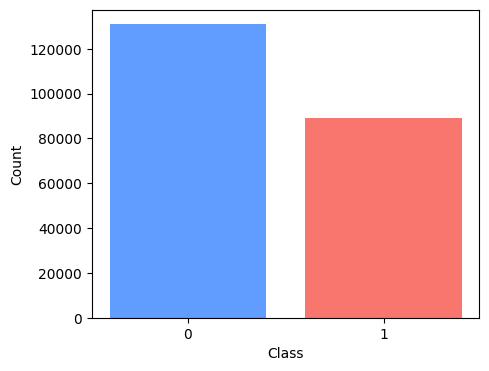

In [10]:
# Gráfico de barras
fig, ax = plt.subplots(figsize = (5,4))
ax.bar(x = [str(i) for i in class_h], height = train_labels['label'].value_counts(), color = ["#619cff", "#f8766d", "#00ba38" ])
ax.set(xlabel = 'Class',ylabel = 'Count');

In [11]:
# Conteo de imágenes en cada clases
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [12]:
# Porcentaje de clase
print('Porcentaje Clase 0:',np.round(100*train_labels['label'].value_counts()[0]/len(train_labels)),'%')
print('Porcentaje Clase 1:',np.round(100*train_labels['label'].value_counts()[1]/len(train_labels)),'%')

Porcentaje Clase 0: 59.0 %
Porcentaje Clase 1: 41.0 %


## Previsualización de imágenes histopatológicas

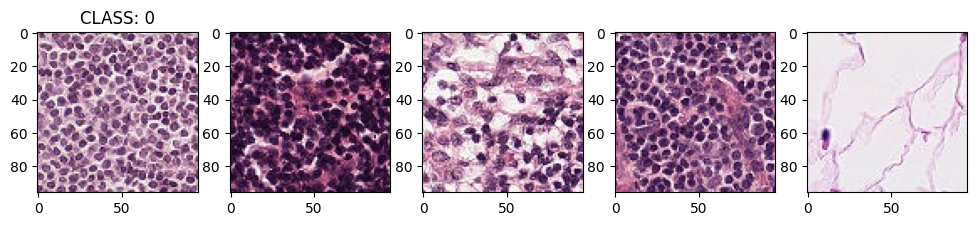

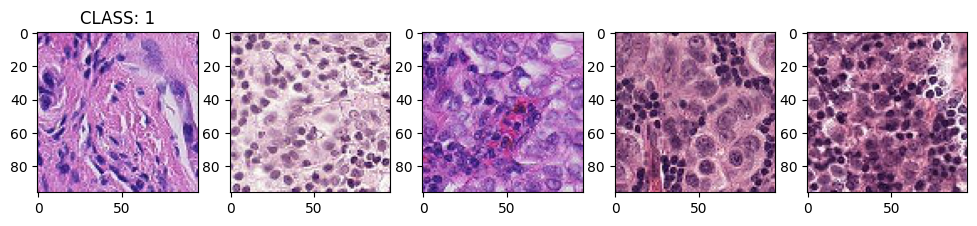

In [13]:
os.chdir("/content/histopathologic-cancer-detection/train")

# Visualización de imágenes aleatorias
show_mosaic_class(class_h)

## Selección de un conjunto de imágenes
Se seleccionará un conjunto de `3x900xnum_class ` imagenes ya que los recursos de Colab-free son limitados para trabajar con el dataset completo y es el mínimo número de imagenes para obtener archivos <25MB que es el requerimeinto de `github` para subir archivos.

In [14]:
id0 = train_labels['id'][0]
img_0 = choose_img(id0,show_plot = 'no')
img_0.shape

(96, 96, 3)

In [15]:
# Escogemos 3*900 imagenes aleatorias por clase y semilla fija
t=3
num_min = 900
Num_img = int(t*num_min*num_class)

## HDF5 files
for j in class_h:
  s=0
  if j == 0:
    sd = 96
  elif j == 1:
    sd = 32
  data_ran = np.random.RandomState(seed=sd).choice(train_labels['id'][train_labels['label']==j],Num_img)
  for i in range(t):
    h5_path = '/content/histopathologic-cancer-detection/H_c'+str(j)+'_0'+str(i)+'.h5'
    h5_w(h5_path,num_min,data_ran[s:s+num_min])
    print(h5_path)
    s+=num_min

0it [00:00, ?it/s]

/content/histopathologic-cancer-detection/H_c0_00.h5


0it [00:00, ?it/s]

/content/histopathologic-cancer-detection/H_c0_01.h5


0it [00:00, ?it/s]

/content/histopathologic-cancer-detection/H_c0_02.h5


0it [00:00, ?it/s]

/content/histopathologic-cancer-detection/H_c1_00.h5


0it [00:00, ?it/s]

/content/histopathologic-cancer-detection/H_c1_01.h5


0it [00:00, ?it/s]

/content/histopathologic-cancer-detection/H_c1_02.h5
